## Imports

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-03-01 09:02:16


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [4]:
from invisible_cities.reco.dst_functions  import load_dst

In [5]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

## NB functions

In [6]:
def plot_csum_csum_mau(csum, csum_mau,
                            t_min      =    0,
                            t_max      = 1200,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6)):
    """Plot signal versus time in mus (tmin, tmax in mus). """
    plt.figure(figsize=figsize)
    tstep = 25 # in ns
    PMTWL = csum.shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlim([t_min, t_max])
    ax1.set_ylim([signal_min, signal_max])
    mpl.set_plot_labels(xlabel = "t (mus)",
                    ylabel = "signal (pes/adc)")
    plt.plot(signal_t, csum, 'b')
    plt.plot(signal_t, csum_mau, 'r')

In [7]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times/units.mus, s12.pmts.waveform(-1))

In [8]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [9]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


## Data base

In [10]:
run_number = 5090
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [11]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [12]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,27.346,0.77,11.551
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,28.257,0.00,12.848
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,29.983,0.81,12.072
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,30.131,0.00,12.006
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,36.064,0.75,13.448
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,26.945,0.75,9.687
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,31.032,0.00,11.675
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,40.055,0.00,15.462
8,8,17,PMT8,1,63.2737,-173.8430,0.000528,5.030400e-07,28.566,0.00,11.466
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,0.000,0.00,0.000


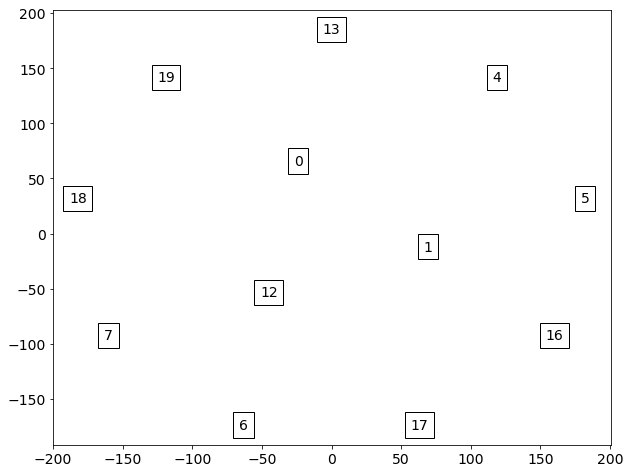

In [13]:
mpl.draw_pmt_map(run_number)

In [14]:
pmt_active

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [15]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,   0.   ,  26.082,  27.499])

In [32]:
adc_to_pes = np.ones(len(adc_to_pes))

In [33]:
adc_to_pes

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

## Input file

In [18]:
filename = '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5090_0010_waveforms.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

In [19]:
pmtrwf = h5rwf.root.RD.pmtrwf

In [20]:
NEVT, NPMT, PMTWL = pmtrwf.shape

In [21]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
      """.format(NEVT, NPMT, PMTWL))


        Number of events in file = 66
        Number of PMTs = 12
        PMTWL = 128000
      


## S1 and S2 parameters

In [22]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 640 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [23]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

## Event 0

In [24]:
event=0

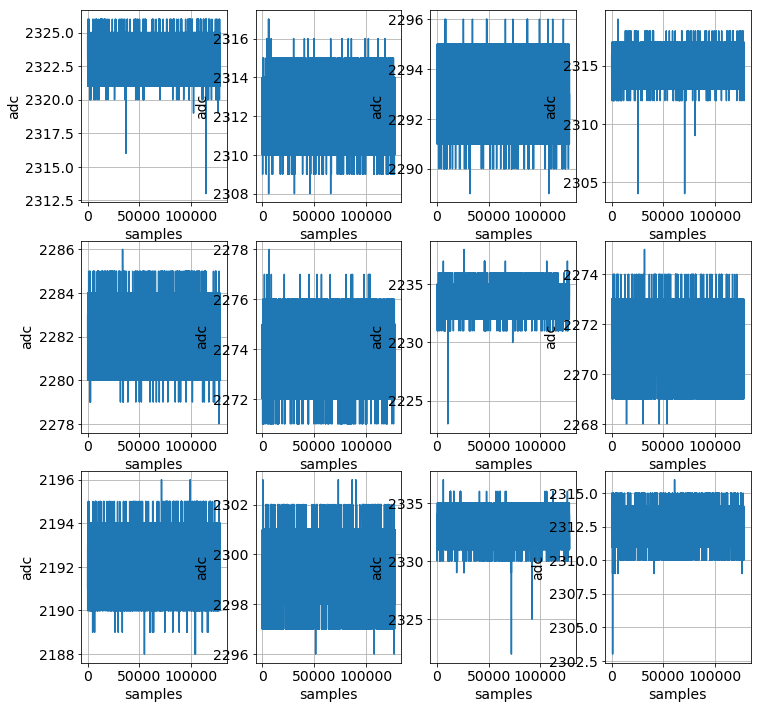

In [25]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

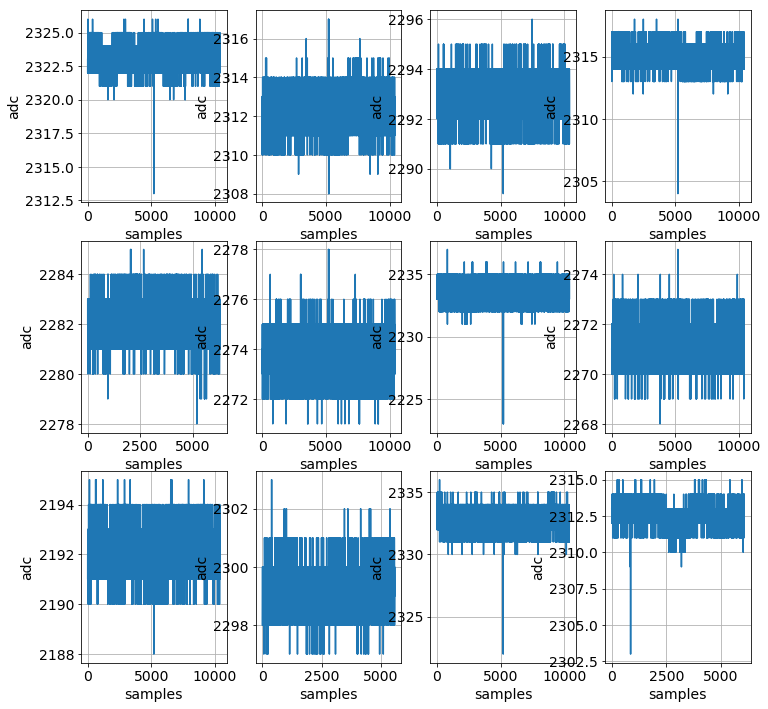

In [26]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=True, window_size=5200, figsize=(12,12))

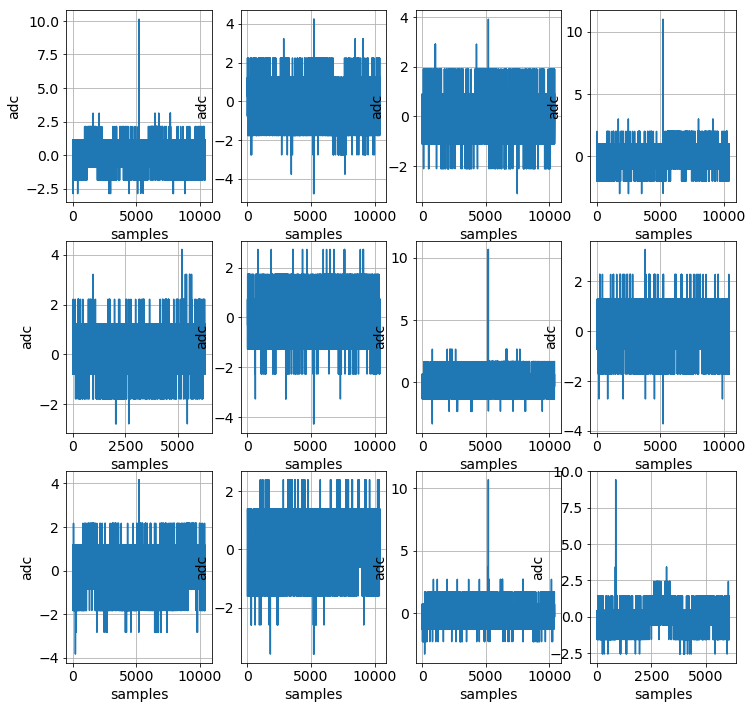

In [27]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=5200, figsize=(12,12))

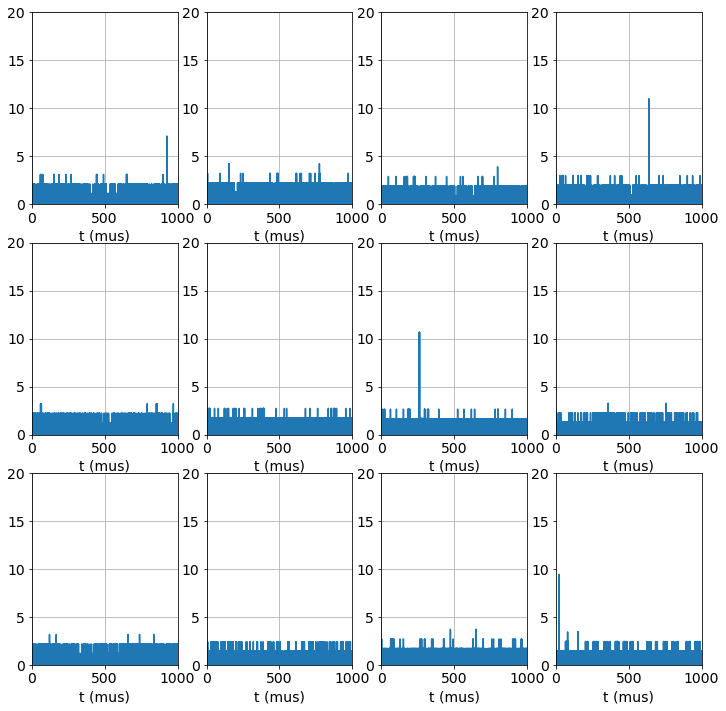

In [39]:
plot_pmt_signals_vs_time_mus(CWF,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 1000,
                                signal_min =    0,
                                signal_max =  20,
                                 figsize=(12,12))

- Calibrated sum

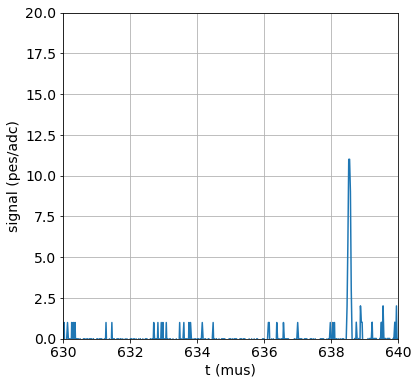

In [54]:
sf.plot_signal_vs_time_mus(CWF[3],
                                t_min      =    630,
                                t_max      = 640,
                                signal_min =    0,
                                signal_max =  20,
                                 figsize=(6,6))

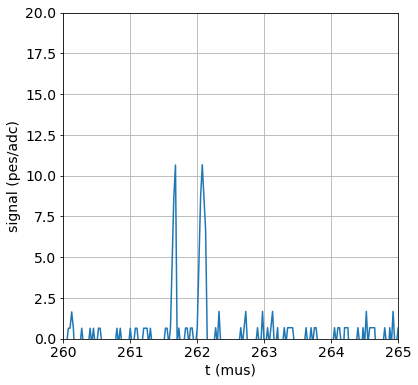

In [57]:
sf.plot_signal_vs_time_mus(CWF[6],
                                t_min      =    260,
                                t_max      = 265,
                                signal_min =    0,
                                signal_max =  20,
                                 figsize=(6,6))

- Double peak observed in one of the PMTs

## Event 1

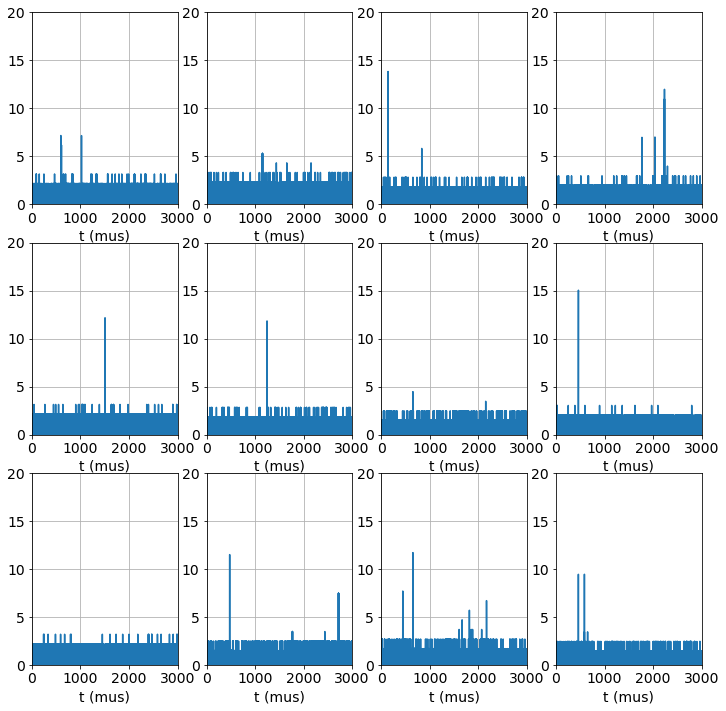

In [61]:
event=1
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
plot_pmt_signals_vs_time_mus(CWF,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 3000,
                                signal_min =    0,
                                signal_max =  20,
                                 figsize=(12,12))

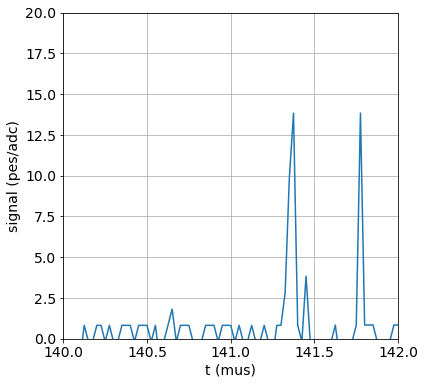

In [64]:
sf.plot_signal_vs_time_mus(CWF[2],
                                t_min      =    140,
                                t_max      = 142,
                                signal_min =    0,
                                signal_max =  20,
                                 figsize=(6,6))

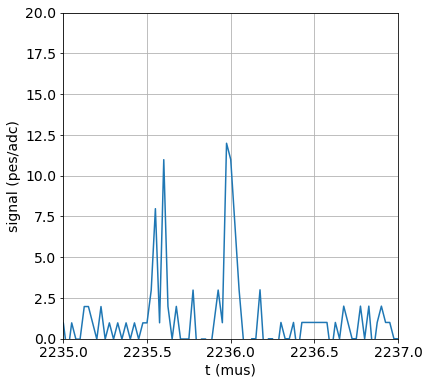

In [75]:
sf.plot_signal_vs_time_mus(CWF[3],
                                t_min      =    2235,
                                t_max      = 2237,
                                signal_min =    0,
                                signal_max =  20,
                                 figsize=(6,6))

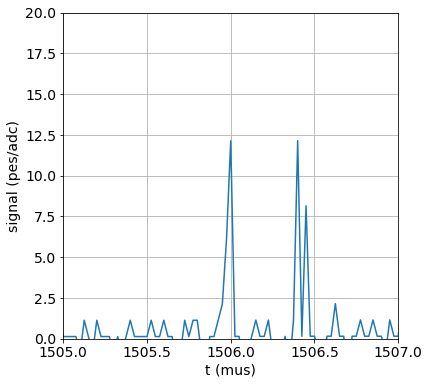

In [79]:
sf.plot_signal_vs_time_mus(CWF[4],
                                t_min      =    1505,
                                t_max      = 1507,
                                signal_min =    0,
                                signal_max =  20,
                                 figsize=(6,6))

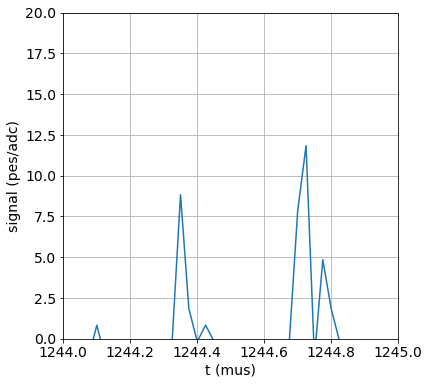

In [83]:
sf.plot_signal_vs_time_mus(CWF[5],
                                t_min      =    1244,
                                t_max      = 1245,
                                signal_min =    0,
                                signal_max =  20,
                                 figsize=(6,6))

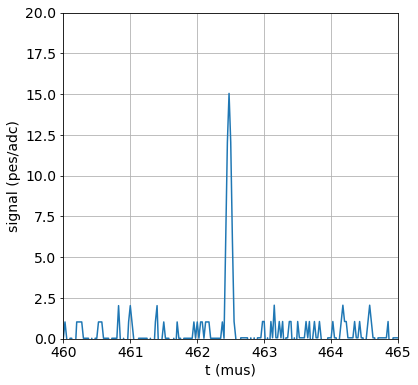

In [72]:
sf.plot_signal_vs_time_mus(CWF[7],
                                t_min      =    460,
                                t_max      = 465,
                                signal_min =    0,
                                signal_max =  20,
                                 figsize=(6,6))

- Double peak observed in MOST of the PMTs